# Experiments Information

### Data

Dataset split: shuffle by seed=42, then split

* Source Activities: Downstairs, Jogging, Upstairs, Walking

    * Train: 80%
    * Val: 10%
    * Test: 10%

* Target Activites: Sitting, Standing

    * Train: 80%
    * Val: 10%
    * Test: 10%

# Imports

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import warnings

from copy import deepcopy
from google.colab import drive
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from tabulate import tabulate

In [7]:
# Supress warnings
warnings.resetwarnings()
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')

# Load Data

In [8]:
if not os.path.exists("drive/"):
    drive.mount('/content/drive')

In [9]:
# # Download data to runtime environment
if not os.path.exists("activity_clusters_df/"):
    ! gdown --folder https://drive.google.com/drive/folders/1CqsUGqC6-8EIY7wOEL58LgpRYxRcnR_4?usp=sharing

In [10]:
import shutil
if not os.path.exists("activity_clusters_df/"):
    os.makedirs("activity_clusters_df/")
    for a in ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]:
        shutil.move("activity_%s_df"%(a), "activity_clusters_df/activity_%s_df"%(a))

In [11]:
# Load files
a = {}
a.update({"downstairs": pd.read_csv("activity_clusters_df/activity_Downstairs_df")})
a.update({"jogging": pd.read_csv("activity_clusters_df/activity_Jogging_df")})
a.update({"sitting": pd.read_csv("activity_clusters_df/activity_Sitting_df")})
a.update({"standing": pd.read_csv("activity_clusters_df/activity_Standing_df")})
a.update({"upstairs": pd.read_csv("activity_clusters_df/activity_Upstairs_df")})
a.update({"walking": pd.read_csv("activity_clusters_df/activity_Walking_df")})
a["downstairs"]

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,396,397,398,399,400,401,402,403,404,label
0,0,0.347781,-0.138535,-0.193372,0.344895,-0.361490,-0.022368,-0.487038,-0.209246,0.295830,...,8.401310,11.536848,7.377326,7.413861,10.035742,23.009137,12.744466,6.154779,14.102396,Downstairs
1,1,-0.021646,-1.033963,-0.129877,0.378807,-0.290780,0.655156,-0.215018,-0.731639,0.127712,...,0.741876,4.400749,4.572016,2.830738,7.404858,12.970116,18.842095,6.662716,3.388563,Downstairs
2,2,0.224398,-0.479101,-0.061331,-0.514456,0.240994,0.315312,-1.046951,-0.044014,0.425707,...,1.313861,0.541320,2.435998,3.155475,7.391318,13.092170,19.106387,8.995701,2.401558,Downstairs
3,3,-0.958202,-0.675359,0.605370,-0.126269,0.044014,0.168840,-0.848528,0.099572,-0.632788,...,1.602404,2.465977,4.372747,3.890775,4.875640,16.151132,17.317576,6.441824,5.470999,Downstairs
4,4,-0.088028,-0.605370,-0.137814,-0.577952,0.523115,-1.020254,-0.762665,0.691233,-0.064217,...,3.811060,4.668090,4.262479,3.276219,5.800673,21.300805,10.898992,7.144370,1.583750,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,951,0.251817,-0.032469,-0.101737,0.016595,-0.176777,-0.327578,-0.005772,0.149358,-0.404061,...,1.483657,1.377412,2.938841,7.620979,16.244419,3.833034,4.081372,1.490163,0.927737,Downstairs
1724,952,-0.550533,0.193372,0.105344,-0.157295,0.025254,-0.264804,0.083698,-0.351389,0.271298,...,0.889991,1.543232,1.624482,3.305709,19.087942,3.713675,1.819241,0.337514,1.048459,Downstairs
1725,953,-0.365820,0.132763,-0.097408,-0.065660,0.069989,-0.346338,-0.209967,-0.198423,0.171726,...,0.865340,1.073513,3.153473,7.171036,13.203347,5.925594,2.963233,3.437277,1.862654,Downstairs
1726,954,-0.450961,-0.481987,0.406947,0.160181,-0.171004,-0.019482,-0.295830,0.146472,-0.428593,...,0.579823,3.242935,5.769628,12.175428,10.336841,1.909687,1.943557,1.214420,1.752679,Downstairs


In [12]:
# View shapes
sorter = []
for k in a:
    sorter.append([k, a[k].shape])
sorter = sorted(sorter, key = lambda x: x[1], reverse=True)
for i in sorter:
    print(i[0] + ":", i[1])

downstairs: (1728, 407)
jogging: (1557, 407)
upstairs: (571, 407)
walking: (456, 407)
sitting: (264, 407)
standing: (198, 407)


# Preprocess Data

In [13]:
# Drop column "Unnamed: 0", was previous index
for k in a:
    a[k].drop("Unnamed: 0", axis=1, inplace=True)
a["downstairs"]

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,label
0,0.347781,-0.138535,-0.193372,0.344895,-0.361490,-0.022368,-0.487038,-0.209246,0.295830,-0.163067,...,8.401310,11.536848,7.377326,7.413861,10.035742,23.009137,12.744466,6.154779,14.102396,Downstairs
1,-0.021646,-1.033963,-0.129877,0.378807,-0.290780,0.655156,-0.215018,-0.731639,0.127712,-0.431479,...,0.741876,4.400749,4.572016,2.830738,7.404858,12.970116,18.842095,6.662716,3.388563,Downstairs
2,0.224398,-0.479101,-0.061331,-0.514456,0.240994,0.315312,-1.046951,-0.044014,0.425707,-0.481266,...,1.313861,0.541320,2.435998,3.155475,7.391318,13.092170,19.106387,8.995701,2.401558,Downstairs
3,-0.958202,-0.675359,0.605370,-0.126269,0.044014,0.168840,-0.848528,0.099572,-0.632788,0.500026,...,1.602404,2.465977,4.372747,3.890775,4.875640,16.151132,17.317576,6.441824,5.470999,Downstairs
4,-0.088028,-0.605370,-0.137814,-0.577952,0.523115,-1.020254,-0.762665,0.691233,-0.064217,-0.305210,...,3.811060,4.668090,4.262479,3.276219,5.800673,21.300805,10.898992,7.144370,1.583750,Downstairs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0.251817,-0.032469,-0.101737,0.016595,-0.176777,-0.327578,-0.005772,0.149358,-0.404061,-0.229449,...,1.483657,1.377412,2.938841,7.620979,16.244419,3.833034,4.081372,1.490163,0.927737,Downstairs
1724,-0.550533,0.193372,0.105344,-0.157295,0.025254,-0.264804,0.083698,-0.351389,0.271298,-0.367984,...,0.889991,1.543232,1.624482,3.305709,19.087942,3.713675,1.819241,0.337514,1.048459,Downstairs
1725,-0.365820,0.132763,-0.097408,-0.065660,0.069989,-0.346338,-0.209967,-0.198423,0.171726,-0.202752,...,0.865340,1.073513,3.153473,7.171036,13.203347,5.925594,2.963233,3.437277,1.862654,Downstairs
1726,-0.450961,-0.481987,0.406947,0.160181,-0.171004,-0.019482,-0.295830,0.146472,-0.428593,0.221512,...,0.579823,3.242935,5.769628,12.175428,10.336841,1.909687,1.943557,1.214420,1.752679,Downstairs


## Encode

In [14]:
# Numeric encode tasks
label_map = {}
for i, row in enumerate(sorter):
    label_map.update({row[0].capitalize(): i})
label_values = list(label_map.keys())
print()
print(label_values)
for k in a:
    a[k].replace({"label": label_map}, inplace=True)
a["downstairs"]


['Downstairs', 'Jogging', 'Upstairs', 'Walking', 'Sitting', 'Standing']


,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,label
0,0.347781,-0.138535,-0.193372,0.344895,-0.361490,-0.022368,-0.487038,-0.209246,0.295830,-0.163067,...,8.401310,11.536848,7.377326,7.413861,10.035742,23.009137,12.744466,6.154779,14.102396,0
1,-0.021646,-1.033963,-0.129877,0.378807,-0.290780,0.655156,-0.215018,-0.731639,0.127712,-0.431479,...,0.741876,4.400749,4.572016,2.830738,7.404858,12.970116,18.842095,6.662716,3.388563,0
2,0.224398,-0.479101,-0.061331,-0.514456,0.240994,0.315312,-1.046951,-0.044014,0.425707,-0.481266,...,1.313861,0.541320,2.435998,3.155475,7.391318,13.092170,19.106387,8.995701,2.401558,0
3,-0.958202,-0.675359,0.605370,-0.126269,0.044014,0.168840,-0.848528,0.099572,-0.632788,0.500026,...,1.602404,2.465977,4.372747,3.890775,4.875640,16.151132,17.317576,6.441824,5.470999,0
4,-0.088028,-0.605370,-0.137814,-0.577952,0.523115,-1.020254,-0.762665,0.691233,-0.064217,-0.305210,...,3.811060,4.668090,4.262479,3.276219,5.800673,21.300805,10.898992,7.144370,1.583750,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0.251817,-0.032469,-0.101737,0.016595,-0.176777,-0.327578,-0.005772,0.149358,-0.404061,-0.229449,...,1.483657,1.377412,2.938841,7.620979,16.244419,3.833034,4.081372,1.490163,0.927737,0
1724,-0.550533,0.193372,0.105344,-0.157295,0.025254,-0.264804,0.083698,-0.351389,0.271298,-0.367984,...,0.889991,1.543232,1.624482,3.305709,19.087942,3.713675,1.819241,0.337514,1.048459,0
1725,-0.365820,0.132763,-0.097408,-0.065660,0.069989,-0.346338,-0.209967,-0.198423,0.171726,-0.202752,...,0.865340,1.073513,3.153473,7.171036,13.203347,5.925594,2.963233,3.437277,1.862654,0
1726,-0.450961,-0.481987,0.406947,0.160181,-0.171004,-0.019482,-0.295830,0.146472,-0.428593,0.221512,...,0.579823,3.242935,5.769628,12.175428,10.336841,1.909687,1.943557,1.214420,1.752679,0


## Split train/val/test

In [15]:
# Shuffle and split datasets
for k in a:
    a[k] = a[k].sample(frac=1, random_state=42)

    train = a[k].sample(frac=0.8, random_state=42)
    
    test = a[k].drop(train.index)
    val = test.sample(frac=0.5, random_state=42)
    test = test.drop(val.index)

    a[k] = {"train": train, "val": val, "test": test}


a["downstairs"]["test"]

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,label
1201,-1.389681,-0.768437,-0.632788,-0.442303,-0.624852,-0.223677,-0.881719,-1.101066,-0.594547,-0.691233,...,6.377698,23.097966,34.745855,31.002063,13.502014,5.365942,17.302269,9.897225,10.672325,0
964,0.865845,-0.771324,-0.486316,-0.751842,1.155903,0.254703,-0.773488,-0.743905,0.111117,0.835540,...,2.825395,2.573991,6.367593,4.187489,1.899719,9.260373,33.115722,5.929711,1.529781,0
413,0.233057,0.585888,-0.114003,0.445189,-0.013709,-0.196258,0.400453,-0.437252,0.228727,0.401175,...,4.028925,4.821610,2.289383,3.686963,5.740266,9.941857,17.784360,4.817460,4.924605,0
548,0.701334,0.724424,0.196980,0.379529,-0.204195,0.367984,1.343503,0.251095,0.776374,0.277070,...,2.443603,3.435704,6.043240,8.907956,29.000425,12.809702,2.070378,4.846413,3.773253,0
1671,-0.103901,-0.143586,-0.041128,0.320363,-0.104623,0.194094,0.411998,0.190486,-0.306653,0.492810,...,5.289757,1.809001,1.676475,1.680219,0.266505,3.511785,1.919212,10.520469,17.055988,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,-0.013709,0.075040,-0.072875,0.105344,0.101737,-0.309540,-0.088028,-0.120497,-0.254703,-0.608256,...,4.129190,3.974917,5.113546,5.618137,14.070138,21.073451,2.994010,3.932900,2.417648,0
699,-0.054837,0.114003,-0.370870,-0.655878,-0.521672,-0.691233,0.522393,-0.850693,-0.839870,0.239550,...,0.936173,1.673157,1.239003,1.715976,3.375701,23.138617,4.755795,2.156915,1.692749,0
459,0.588775,0.146472,0.555584,0.547647,0.210689,0.909137,0.614750,0.654435,0.795856,1.135700,...,0.863662,1.869787,1.517108,3.072035,18.275238,3.599495,1.361696,1.953886,1.474018,0
871,0.381693,0.442303,0.093800,0.386744,-0.298717,-0.088749,0.432923,-0.317477,-0.411998,0.356440,...,2.072231,2.458438,1.006014,19.762199,2.622684,2.806861,4.014831,5.073175,3.007891,0


In [16]:
# Combine Source and target activites
data = {"source": {"train": None, "val": None, "test": None}, "target": {"train": None, "val": None, "test": None}, "comb": {"train": None, "val": None, "test": None}}

data["source"]["train"] = pd.concat([a["downstairs"]["train"], a["jogging"]["train"], a["upstairs"]["train"], a["walking"]["train"]], axis=0, ignore_index=True)
data["source"]["val"] = pd.concat([a["downstairs"]["val"], a["jogging"]["val"], a["upstairs"]["val"], a["walking"]["val"]], axis=0, ignore_index=True)
data["source"]["test"] = pd.concat([a["downstairs"]["test"], a["jogging"]["test"], a["upstairs"]["test"], a["walking"]["test"]], axis=0, ignore_index=True)

data["target"]["train"] = pd.concat([a["sitting"]["train"], a["standing"]["train"]], axis=0, ignore_index=True)
data["target"]["val"] = pd.concat([a["sitting"]["val"], a["standing"]["val"]], axis=0, ignore_index=True)
data["target"]["test"] = pd.concat([a["sitting"]["test"], a["standing"]["test"]], axis=0, ignore_index=True)

data["comb"]["train"] = pd.concat([a["downstairs"]["train"], a["jogging"]["train"], a["upstairs"]["train"], a["walking"]["train"], a["sitting"]["train"], a["standing"]["train"]], axis=0, ignore_index=True)
data["comb"]["val"] = pd.concat([a["downstairs"]["val"], a["jogging"]["val"], a["upstairs"]["val"], a["walking"]["val"], a["sitting"]["val"], a["standing"]["val"]], axis=0, ignore_index=True)
data["comb"]["test"] = pd.concat([a["downstairs"]["test"], a["jogging"]["test"], a["upstairs"]["test"], a["walking"]["test"], a["sitting"]["test"], a["standing"]["test"]], axis=0, ignore_index=True)

In [17]:
# View shapes
for k1 in data:
    print(k1, " =============================================")
    for k2 in data[k1]:
        print(k2, " ", data[k1][k2].shape)
    print()

source  =============================================
train   (3450, 406)
val   (432, 406)
test   (430, 406)

target  =============================================
train   (369, 406)
val   (46, 406)
test   (47, 406)

comb  =============================================
train   (3819, 406)
val   (478, 406)
test   (477, 406)



In [18]:
# Shuffle
for k1 in data:
    for k2 in data[k1]:
        data[k1][k2] = data[k1][k2].sample(frac=1, random_state=42)
data["target"]["test"]

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,label
27,-0.945214,-0.948100,-0.928619,-0.940163,-0.939442,-0.945214,-0.929340,-0.933670,-0.939442,-0.934391,...,0.144262,0.079154,0.183547,0.185953,0.248063,0.131990,0.129237,0.111134,0.268732,5
39,-0.196980,-0.207803,-0.212854,-0.229449,-0.194094,-0.191207,-0.204917,-0.204917,-0.190486,-0.199144,...,0.133540,0.189815,0.238591,0.214635,0.008080,0.150123,0.168663,0.110836,0.122620,5
26,0.229449,0.232335,0.232335,0.226563,0.226563,0.232335,0.229449,0.226563,0.229449,0.229449,...,1.880219,0.190019,1.755064,0.175249,1.665210,0.192309,1.553323,0.177241,1.521029,4
43,-0.124826,-0.134206,-0.146472,-0.137092,-0.126269,-0.132041,-0.137092,-0.134206,-0.137092,-0.137092,...,0.076726,0.027835,0.039110,0.048211,0.136854,0.148528,0.138518,0.112994,0.071880,5
24,0.134206,0.124826,0.129877,0.128434,0.121218,0.128434,0.126269,0.128434,0.132763,0.128434,...,0.264158,0.062952,0.312728,0.223765,0.172969,0.291265,0.212392,0.275663,0.195294,4
36,-0.199866,-0.235221,-0.218626,-0.202031,-0.202752,-0.207803,-0.215740,-0.207803,-0.204917,-0.240994,...,0.492353,0.190280,0.242284,0.358666,0.345047,0.272525,0.167364,0.151443,0.342169,5
12,0.832654,0.832654,0.829768,0.826882,0.829768,0.823996,0.823996,0.832654,0.826882,0.826882,...,0.036258,0.029791,0.052171,0.133756,0.044947,0.080735,0.040027,0.059444,0.110168,4
19,0.933670,0.931505,0.936556,0.931505,0.931505,0.931505,0.933670,0.928619,0.931505,0.936556,...,0.080441,0.018828,0.047001,0.026592,0.021779,0.043337,0.025553,0.010653,0.031541,4
4,0.210689,0.202031,0.207803,0.204917,0.213575,0.210689,0.213575,0.207803,0.210689,0.215740,...,0.031883,0.102569,0.087867,0.028671,0.018775,0.062245,0.033283,0.104598,0.064072,4
25,0.093800,0.116889,0.184714,0.069268,0.142143,0.131320,0.127712,0.107509,0.119054,0.149358,...,0.129379,0.268797,0.337266,0.205890,0.409909,0.236516,0.464918,0.268131,0.268319,4


## Split Sample and Label

In [19]:
# Split
def split_x_y(df, img_rows, img_cols):

    # Flat data
    x = df[df.columns[:-1]]
    y = df[["label"]]

    # Image data
    shaped = x.to_numpy(copy=True)
    shaped = np.reshape(shaped, (shaped.shape[0], img_rows, img_cols))

    return{"df": df, "x": x, "y": y, "x_shaped": shaped}

img_rows = 27
img_cols = 15

for k1 in data:
    for k2 in data[k1]:
        data[k1][k2] = split_x_y(data[k1][k2], img_rows, img_cols)

In [20]:
# View shapes
def view_data_shapes(data):
    for k1 in data:
        print(k1, "=============================================")
        for k2 in data[k1]:
            print(k2, "---------------------------------------------")
            for k3 in data[k1][k2]:
                print(k3, " ", data[k1][k2][k3].shape)
            print()
        print()

view_data_shapes(data)

source =============================================
train ---------------------------------------------
df   (3450, 406)
x   (3450, 405)
y   (3450, 1)
x_shaped   (3450, 27, 15)

val ---------------------------------------------
df   (432, 406)
x   (432, 405)
y   (432, 1)
x_shaped   (432, 27, 15)

test ---------------------------------------------
df   (430, 406)
x   (430, 405)
y   (430, 1)
x_shaped   (430, 27, 15)


target =============================================
train ---------------------------------------------
df   (369, 406)
x   (369, 405)
y   (369, 1)
x_shaped   (369, 27, 15)

val ---------------------------------------------
df   (46, 406)
x   (46, 405)
y   (46, 1)
x_shaped   (46, 27, 15)

test ---------------------------------------------
df   (47, 406)
x   (47, 405)
y   (47, 1)
x_shaped   (47, 27, 15)


comb =============================================
train ---------------------------------------------
df   (3819, 406)
x   (3819, 405)
y   (3819, 1)
x_shaped   (3819, 27

In [21]:
del a
del train, test, val
del sorter

# Models

## Single Model Handler

In [22]:
class ModelHandler():
    
    def __init__(self, name, labels_to_values_map, checkpoint_path="checkpoints/", checkpoint_file_name="cp.ckpt"):
        self.model_name = name
        self.labels_to_values_map = labels_to_values_map
        self.checkpoint_path = checkpoint_path
        self.checkpoint_file_name = checkpoint_file_name
        self.cp_paths = {}
        self.cp_callbacks = {}
        self.hist = {}
            
    # Build model ==============================================================
    def build_model(self, model_type, input_shape, n_labels=6, learning_rate=0.001, metrics=["accuracy"], drop=False):
        if model_type not in ["dense", "conv"]:
            print(model_type, "is an invalid model type. Please enter a value in [\"dense\", \"conv\"].")
        self.model_type = model_type
        self.input_shape = input_shape
        self.n_labels = n_labels
        self.learning_rate = learning_rate
        self.metrics = metrics
        self.drop = drop
        
        # Build dense model
        if model_type == "dense":
            self.model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
            if not drop:
                self.model.add(tf.keras.layers.Dense(405, activation="relu"))
            self.model.add(tf.keras.layers.Dense(202, activation="relu"))
            if not drop:
                self.model.add(tf.keras.layers.Dense(101, activation="relu"))

        # Build cnn model
        elif model_type == "conv":
            self.model = tf.keras.Sequential([tf.keras.layers.Input(shape=input_shape)])
            self.model.add(tf.keras.layers.Conv2D(32, kernel_size=(1, 1),
                                                  activation='relu',
                                                  input_shape=input_shape
                                                  ))
            if not drop:
                self.model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
            self.model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
            if not drop:
                self.model.add(tf.keras.layers.Dropout(0.25))
            self.model.add(tf.keras.layers.Flatten())
            self.model.add(tf.keras.layers.Dense(128, activation='relu'))
            if not drop:
                self.model.add(tf.keras.layers.Dropout(0.5))

        self.model.add(tf.keras.layers.Dense(n_labels, activation="softmax"))
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                           metrics=metrics
                           )
    
    def build_transfer_model(self, train_layers):
        for layer in self.model.layers[:-train_layers]:
            layer.trainable = False
        self.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
                           metrics=self.metrics
                           )
        
    # Train model ==============================================================

    # Checkpointing ------------------------------------------------------------
    def setup_checkpointing(self, experiment_level):

        # Paths
        if experiment_level not in self.cp_paths:
            self.cp_paths.update({experiment_level: "%s%s"%(self.checkpoint_path, self.checkpoint_file_name)})
        if not os.path.exists(self.cp_paths[experiment_level]):
            os.makedirs(self.cp_paths[experiment_level])

        # Callbacks
        if experiment_level not in self.cp_callbacks:
            self.cp_callbacks.update({experiment_level: tf.keras.callbacks.ModelCheckpoint(filepath=self.cp_paths[experiment_level],
                                                                                           save_weights_only=True,
                                                                                           verbose=1, 
                                                                                           save_freq="epoch",
                                                                                           save_best_only=True
                                                                                           )
                                      })
    
    # Training -----------------------------------------------------------------
    def train_model(self, experiment_level, train_x, train_y, val_x, val_y, epochs=10):

        # Setup checkpoints
        self.setup_checkpointing(experiment_level)

        # Update history dictionary
        if experiment_level not in self.hist:
            self.hist.update({experiment_level: None})

        # Train
        self.hist[experiment_level] = self.model.fit(train_x, train_y, 
                                                     validation_data=(val_x, val_y), 
                                                     epochs=epochs, 
                                                     callbacks=[self.cp_callbacks[experiment_level]]
                                                     )
        
        # Load best
        self.model.load_weights(self.cp_paths[experiment_level])

    # Evaluate =================================================================
    def evaluate(self, test_x, test_y, verbose=True):
        preds =  self.model.predict(test_x)
        preds_select = np.apply_along_axis(np.argmax, 1, preds)
        true = [y[0] for y in test_y.values]

        loss, acc = self.model.evaluate(test_x, test_y, verbose=2)
        scores = precision_recall_fscore_support(true, preds_select, average='macro')
        pre = scores[0]
        re = scores[1]
        f1 = scores[2]
        auc = np.nan
        try:
            auc = roc_auc_score(true, preds, multi_class="ovo")
        except:
            auc = np.nan

        report = classification_report(true, preds_select)
        cm = confusion_matrix(true, preds_select, labels=list(self.labels_to_values_map.values()))

        if verbose:
            print("\nModel Results:")
            print("Loss: %f\nAccuracy: %f\nPrecision: %f\nRecall: %f\nF1: %f\nAUC: %f\n"%(loss, acc, pre, re, f1, auc))
            print("Classification Report:")
            print(report)
            print("\nConfusion Matrix:")
            print(tabulate([[k] + list(cm[i]) for i, k in enumerate(list(self.labels_to_values_map.keys()))], 
                        ["Activity"] + list(label_map.keys()), 
                        tablefmt="grid")
            )

        return loss, acc, pre, re, f1, auc, preds, report, cm

## Model Archetype Handler

In [23]:
class ModelArchetypeHandler():

    def __init__(self, archetype_name, experiment_name, labels_to_values_map, save_dir="", checkpoint_path="checkpoints/", checkpoint_file_name="cp.ckpt"):
        self.archetype_name = archetype_name
        self.experiment_name = experiment_name
        self.labels_to_values_map = labels_to_values_map
        self.save_dir = save_dir
        self.checkpoint_path = save_dir + checkpoint_path
        self.checkpoint_file_name = checkpoint_file_name
        self.hist = {}
        self.tracker = None
        self.names = ["naive", "initial_target", "transfer_target", "initial_comb", "transfer_comb"]

    # Build and Train Models ===================================================
    def run_experiment(self, input_shape, train_layers, 
                       data, x_key,
                       n_labels=6, learning_rate=0.001, metrics=["accuracy"], drop=False, 
                       epochs=10, n_runs=5, 
                       verbose=True
                       ):
        
        tracker = []
        for run in range(n_runs):
            for n in self.names:
                if n not in self.hist:
                    self.hist.update({n: {}})
                if run not in self.hist[n]:
                    self.hist[n].update({run: None})

            # Naive model
            level = "naive"
            header = "\n\nRun %d, %s, %s ===="%(run, self.archetype_name, level)
            print(header.ljust(85, "="))
            self.n_model = ModelHandler(name="%s_%s_%d"%(self.archetype_name, level, run), 
                                        labels_to_values_map=self.labels_to_values_map, 
                                        checkpoint_path="%s%s/%s/%d/"%(self.checkpoint_path, self.archetype_name, level, run), 
                                        checkpoint_file_name=self.checkpoint_file_name
                                        )
            self.n_model.build_model(self.archetype_name, input_shape, n_labels, learning_rate, metrics, drop)
            self.n_model.train_model(level, 
                                     data["comb"]["train"][x_key], data["comb"]["train"]["y"], 
                                     data["comb"]["val"][x_key], data["comb"]["val"]["y"], 
                                     epochs*2
                                     )
            self.hist[level][run] = self.n_model.hist[level]
            for test in ["source", "target", "comb"]:
                loss, acc, pre, re, f1, auc, preds, report, cm = self.n_model.evaluate(data[test]["test"][x_key], 
                                                                                       data[test]["test"]["y"], 
                                                                                       verbose=verbose
                                                                                       )
                tracker.append([self.archetype_name, level, run, test, loss, acc, pre, re, f1, auc, report, cm, preds, self.n_model.hist[level]])

            # Initial target model
            level = "initial_target"
            header = "\n\nRun %d, %s, %s ===="%(run, self.archetype_name, level)
            print(header.ljust(85, "="))
            self.t_target_model = ModelHandler(name="%s_%s_%d"%(self.archetype_name, level, run),
                                               labels_to_values_map=self.labels_to_values_map, 
                                               checkpoint_path="%s%s/%s/%d/"%(self.checkpoint_path, self.archetype_name, level, run), 
                                               checkpoint_file_name=self.checkpoint_file_name
                                               )
            self.t_target_model.build_model(self.archetype_name, input_shape, n_labels, learning_rate, metrics, drop)
            self.t_target_model.train_model(level, 
                                            data["comb"]["train"][x_key], data["comb"]["train"]["y"], 
                                            data["comb"]["val"][x_key], data["comb"]["val"]["y"], 
                                            epochs
                                            )
            self.hist[level][run] = self.t_target_model.hist[level]
            for test in ["source", "target", "comb"]:
                loss, acc, pre, re, f1, auc, preds, report, cm = self.t_target_model.evaluate(data[test]["test"][x_key], 
                                                                                              data[test]["test"]["y"], 
                                                                                              verbose=verbose
                                                                                              )
                tracker.append([self.archetype_name, level, run, test, loss, acc, pre, re, f1, auc, report, cm, preds, self.t_target_model.hist[level]])

            # Transfer target model
            level = "transfer_target"
            header = "\n\nRun %d, %s, %s ===="%(run, self.archetype_name, level)
            print(header.ljust(85, "="))
            self.t_target_model.build_transfer_model(train_layers)
            self.t_target_model.train_model(level, 
                                            data["comb"]["train"][x_key], data["comb"]["train"]["y"], 
                                            data["comb"]["val"][x_key], data["comb"]["val"]["y"], 
                                            epochs
                                            )
            self.hist[level][run] = self.t_target_model.hist[level]
            for test in ["source", "target", "comb"]:
                loss, acc, pre, re, f1, auc, preds, report, cm = self.t_target_model.evaluate(data[test]["test"][x_key], 
                                                                                              data[test]["test"]["y"], 
                                                                                              verbose=verbose
                                                                                              )
                tracker.append([self.archetype_name, level, run, test, loss, acc, pre, re, f1, auc, report, cm, preds, self.t_target_model.hist[level]])
                
            # Initial comb model
            level = "initial_comb"
            header = "\n\nRun %d, %s, %s ===="%(run, self.archetype_name, level)
            print(header.ljust(85, "="))
            self.t_comb_model = ModelHandler(name="%s_%s_%d"%(self.archetype_name, level, run),
                                             labels_to_values_map=self.labels_to_values_map, 
                                             checkpoint_path="%s%s/%s/%d/"%(self.checkpoint_path, self.archetype_name, level, run), 
                                             checkpoint_file_name=self.checkpoint_file_name
                                             )
            self.t_comb_model.build_model(self.archetype_name, input_shape, n_labels, learning_rate, metrics, drop)
            self.t_comb_model.train_model(level, 
                                         data["comb"]["train"][x_key], data["comb"]["train"]["y"], 
                                         data["comb"]["val"][x_key], data["comb"]["val"]["y"], 
                                         epochs
                                         )
            self.hist[level][run] = self.t_comb_model.hist[level]
            for test in ["source", "target", "comb"]:
                loss, acc, pre, re, f1, auc, preds, report, cm = self.t_comb_model.evaluate(data[test]["test"][x_key], 
                                                                                             data[test]["test"]["y"], 
                                                                                             verbose=verbose
                                                                                             )
                tracker.append([self.archetype_name, level, run, test, loss, acc, pre, re, f1, auc, report, cm, preds, self.t_comb_model.hist[level]])

            # Transfer comb model
            level = "transfer_comb"
            header = "\n\nRun %d, %s, %s ===="%(run, self.archetype_name, level)
            print(header.ljust(85, "="))
            self.t_comb_model.build_transfer_model(train_layers)
            self.t_comb_model.train_model(level, 
                                         data["comb"]["train"][x_key], data["comb"]["train"]["y"], 
                                         data["comb"]["val"][x_key], data["comb"]["val"]["y"], 
                                         epochs
                                         )
            self.hist[level][run] = self.t_comb_model.hist[level]
            for test in ["source", "target", "comb"]:
                loss, acc, pre, re, f1, auc, preds, report, cm = self.t_comb_model.evaluate(data[test]["test"][x_key], 
                                                                                             data[test]["test"]["y"], 
                                                                                             verbose=verbose
                                                                                             )
                tracker.append([self.archetype_name, level, run, test, loss, acc, pre, re, f1, auc, report, cm, preds, self.t_comb_model.hist[level]])

        # Get run averages -----------------------------------------------------

        # Set up averages collecter
        averages = {}
        for level in list(self.names):
            averages.update({level: {}})
            for test in ["source", "target", "comb"]:
                averages[level].update({test: [0, 0, 0, 0, 0, 0]})
        
        # Get scores
        for row in tracker:
            for i in range(4, 10):
                averages[row[1]][row[3]][i-4] += row[i]
        
        # Add average scores to tracker
        for level in list(self.names):
            for test in ["source", "target", "comb"]:
                avg = [self.archetype_name, level, -1, test, 
                       averages[level][test][0]/n_runs, 
                       averages[level][test][1]/n_runs, 
                       averages[level][test][2]/n_runs, 
                       averages[level][test][3]/n_runs, 
                       averages[level][test][4]/n_runs, 
                       averages[level][test][5]/n_runs, 
                       np.nan, np.nan, np.nan, np.nan
                       ]
                tracker.append(avg)

        # To dataframe
        self.tracker = sorted(tracker, key=lambda x: (x[0], x[1], x[2], x[3]))
        self.tracker = pd.DataFrame(self.tracker, columns=["model_archetype", "model_type", 
                                                 "run", "test_level", "loss", 
                                                 "accuracy", "precision", 
                                                 "recall", "f1", "auc", "report", "confusion_matrix", 
                                                 "predictions", "history"
                                                 ])
        self.tracker["exp_name"] = [self.experiment_name] * self.tracker.shape[0]
        
        return self.tracker

## Dual Model Archetype Handler

In [24]:
class DualModelArchetypeHandler():

    def __init__(self, experiment_name, labels_to_values_map, save_dir="", checkpoint_path="checkpoints/", checkpoint_file_name="cp.ckpt"):
        self.experiment_name = experiment_name
        self.labels_to_values_map = labels_to_values_map
        self.save_dir = save_dir
        self.checkpoint_path = checkpoint_path
        self.checkpoint_file_name = checkpoint_file_name

        self.dense_handler = ModelArchetypeHandler("dense", self.experiment_name, self.labels_to_values_map, self.save_dir, self.checkpoint_path, self.checkpoint_file_name)
        self.conv_handler = ModelArchetypeHandler("conv", self.experiment_name, self.labels_to_values_map, self.save_dir, self.checkpoint_path, self.checkpoint_file_name)
        
    def run_experiment(self, dense_input_shape, conv_input_shape, 
                       dense_train_layers, conv_train_layers, 
                       data, n_labels=6, learning_rate=0.001, metrics=["accuracy"], drop=False, 
                       epochs=10, n_runs=5, 
                       verbose=True
                       ):
        
        self.dense_handler.run_experiment(input_shape=dense_input_shape, train_layers=dense_train_layers, 
                       data=data, x_key="x",
                       n_labels=n_labels, learning_rate=learning_rate, metrics=metrics, drop=drop, 
                       epochs=epochs, n_runs=n_runs, 
                       verbose=verbose)
        
        self.conv_handler.run_experiment(input_shape=conv_input_shape, train_layers=conv_train_layers, 
                       data=data, x_key="x_shaped",
                       n_labels=n_labels, learning_rate=learning_rate, metrics=metrics, drop=drop, 
                       epochs=epochs, n_runs=n_runs, 
                       verbose=verbose)
        
        self.dual_tracker = pd.concat([self.dense_handler.tracker, self.conv_handler.tracker])
        self.dual_tracker.to_csv(self.save_dir + "trackers/" + self.experiment_name + "_dual" + ".csv", index=False)

        return self.dual_tracker

# Plotting

## History

In [25]:
def plot_histories(dual_handler, n_runs, epochs, save=False, save_dir="", save_name=""):
    fig, ax = plt.subplots(6, 4, figsize=(15, 20))
    # col 0: accuracy
    # col 1: val accuracy
    # col 2: loss
    # col 3: val loss
    # row 0: dense naive
    # row 1: dense transfer target val
    # row 2: dense transfer comb val
    # row 3: conv naive
    # row 4: conv transfer target val
    # row 5: conv transfer comb val

    # Subplot labels ===========================================================
    for i, architecture in enumerate(["Dense", "Conv."]):
        for k, model in enumerate(["Naive", "Transfer Target", "Transfer Combined"]):
            for j, metric in enumerate(["Accuracy", "Val. Accuracy", "Loss", "Val. Loss"]):
                row = k
                if i > 0:
                    row += 3
                ax[row][j].set_xlabel("Epochs")
                ax[row][j].set_ylabel(metric)
                ax[row][j].set_title(" ".join([architecture, model, metric]))

    # Subplots =================================================================
    labels = []
    avgs = {"accuracy": None, 
            "val_accuracy": None, 
            "loss": None, 
            "val_loss": None
            }
    for run in range(n_runs):
        labels.append("Run %d"%(run + 1))
        for j, score in enumerate(["accuracy", "val_accuracy", "loss", "val_loss"]):

            # Dense
            ax[0][j].plot(dual_handler.dense_handler.hist["naive"][run].history[score])
            ax[1][j].plot(dual_handler.dense_handler.hist["initial_target"][run].history[score] + dual_handler.dense_handler.hist["transfer_target"][run].history[score])
            ax[2][j].plot(dual_handler.dense_handler.hist["initial_comb"][run].history[score] + dual_handler.dense_handler.hist["transfer_comb"][run].history[score])

            # Conv
            ax[3][j].plot(dual_handler.conv_handler.hist["naive"][run].history[score])
            ax[4][j].plot(dual_handler.conv_handler.hist["initial_target"][run].history[score] + dual_handler.conv_handler.hist["transfer_target"][run].history[score])
            ax[5][j].plot(dual_handler.conv_handler.hist["initial_comb"][run].history[score] + dual_handler.conv_handler.hist["transfer_comb"][run].history[score])

    # Plot limits ==============================================================

    # Get values ---------------------------------------------------------------
    loss = [None, None]
    for i in range(6):
        for j in range(2):

            # Loss min
            if loss[0] is None:
                loss[0] = ax[i][j+2].get_ylim()[0]
            elif loss[0] > ax[i][j+2].get_ylim()[0]:
                loss[0] = ax[i][j+2].get_ylim()[0]

            # Loss max
            if loss[1] is None:
                loss[1] = ax[i][j+2].get_ylim()[1]
            elif loss[1] < ax[i][j+2].get_ylim()[1]:
                loss[1] = ax[i][j+2].get_ylim()[1]
                
    # Set values ---------------------------------------------------------------
    for i in range(6):
        for j in range(2):
            ax[i][j].set_ylim((0, 1))
            ax[i][j+2].set_ylim(loss)
    plt.setp(ax, xlim=(0, epochs*2-1))

    # Plot =====================================================================
    fig.legend(labels=labels, loc="upper right")
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    if save:
        plt.savefig(save_dir + save_name)
    plt.plot()

## Tracker Results

In [26]:
def plot_scores(tracker, save=False, save_dir="", save_name=""):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))

    metrics = [["precision", "recall"], ["accuracy", "f1"]]
    types = ["naive", "initial_target", "transfer_target", "initial_comb", "transfer_comb"]
    test_sets = ["target", "comb"]
    archs = ["dense", "conv"]
    colors = [["xkcd:light orange", "xkcd:orange"], ["xkcd:sky blue", "xkcd:deep sky blue"]]
    label_keys = []

    for a in archs:
        for t in test_sets:
            label_keys.append(a + " " + t)

    # Get scores
    for i in range(2):
        for j in range(2):
            m = metrics[i][j]
            df = tracker.loc[tracker["run"] == -1]

            w = 0.2
            x_ticks = {0: np.arange(len(types))}
            c = 0
            for k, a in enumerate(archs):
                for l, t in enumerate(test_sets):
                    tmp = df.loc[(df["test_level"] == t) & (df["model_archetype"] == a)]
                    vals = tmp[m].tolist()
                    vals = [vals[2], vals[1], vals[4], vals[0], vals[3]]
                    idx = label_keys.index("%s %s"%(a, t))
                    ax[i][j].bar(x_ticks[c], vals, width=w, color=colors[k][l], label=label_keys[idx])
                    c += 1
                    x_ticks.update({c: [x + w for x in x_ticks[c-1]]})

            ax[i][j].set_xlabel("Model Type")
            ax[i][j].set_ylabel("Score")
            ax[i][j].set_title(m.capitalize())

    plt.setp(ax, xticks=[x + w for x in range(len(types))], xticklabels=types)
    plt.tight_layout()
    plt.subplots_adjust(right=0.9)
    plt.legend(labels=label_keys, loc="upper right")
    if save:
        plt.savefig(save_dir + save_name)
    plt.show()

# Experiments

## Global Hyperparameters

In [27]:
lables_to_values_map = deepcopy(label_map)
labels_list = list(lables_to_values_map.keys())

# File Handling
save_dir = "/content/drive/MyDrive/AI in healthcare and Wearables/Results/"
checkpoint_path = "checkpoints/exp_"
cp_file = "checkpoint.ckpt"
hist_plot_dir = save_dir + "hist_plots/"
tracker_bar_dir = save_dir + "tracker_bar_plots/"

# Model hyperparmeters
n_labels = 6
input_shape_dense = (405, )
input_shape_conv = (img_rows, img_cols, 1)
epochs = 5
n_runs = 5

# History
tracker_global = {}

## Experiment 8 - Reduce Data and Drop Learning Rate and Drop Layers

### Hyperparameters

In [28]:
exp_name = "008_reduce_data_and_drop_learning_rate_and_layers"

# File handling
exp_checkpoint_path = checkpoint_path + exp_name + "/"

# Data
keep = 0.5

# Training
learning_rate = 0.00001
dense_train_layers = 1
conv_train_layers = 2
drop = True

### Select Data

In [29]:
data_new = {}
for k1 in data.keys():
    data_new.update({k1: {}})
    for k2 in data[k1].keys():
        data_new[k1].update({k2: {}})
        df = []
        for i in range(n_labels):
            tmp = data[k1][k2]["df"].loc[data[k1][k2]["df"]["label"] == i]
            df.append(tmp.sample(frac=keep, random_state=42))
        df = pd.concat(df, axis=0, ignore_index=True)
        df = df.sample(frac=1, random_state=42)
        data_new[k1][k2] = split_x_y(df, img_rows, img_cols)

view_data_shapes(data_new)
data_new["source"]["train"]["df"]

source =============================================
train ---------------------------------------------
df   (1724, 406)
x   (1724, 405)
y   (1724, 1)
x_shaped   (1724, 27, 15)

val ---------------------------------------------
df   (215, 406)
x   (215, 405)
y   (215, 1)
x_shaped   (215, 27, 15)

test ---------------------------------------------
df   (214, 406)
x   (214, 405)
y   (214, 1)
x_shaped   (214, 27, 15)


target =============================================
train ---------------------------------------------
df   (185, 406)
x   (185, 405)
y   (185, 1)
x_shaped   (185, 27, 15)

val ---------------------------------------------
df   (23, 406)
x   (23, 405)
y   (23, 1)
x_shaped   (23, 27, 15)

test ---------------------------------------------
df   (24, 406)
x   (24, 405)
y   (24, 1)
x_shaped   (24, 27, 15)


comb =============================================
train ---------------------------------------------
df   (1909, 406)
x   (1909, 405)
y   (1909, 1)
x_shaped   (1909, 27

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,label
300,0.320363,0.857187,0.829047,0.024532,-0.181827,-0.597433,1.204968,0.098851,0.132763,0.339844,...,2.133983,1.578392,3.563417,2.017301,4.984403,14.182146,17.995760,3.660694,4.836455,0
1075,2.551357,0.313869,-1.011596,1.334123,0.484152,2.642270,0.075040,0.075040,2.650207,-0.511570,...,24.012504,42.345851,42.242076,53.502069,28.588099,10.983309,8.346036,7.301008,11.809258,1
535,-0.693398,0.069268,-0.388909,-0.020203,0.175334,-0.886048,-0.445189,-0.587332,-0.190486,0.505798,...,4.587014,3.348677,9.101283,4.118681,13.213393,3.135425,5.226459,4.840974,4.066516,0
1318,0.207081,-0.086585,-0.105344,0.292944,-0.019482,0.027418,-0.111117,0.155131,0.049065,0.466835,...,0.850289,1.206582,2.779558,1.013882,3.574368,2.959568,4.751655,1.535385,4.231575,2
561,0.484152,0.143586,0.944493,1.175385,-0.072154,0.184714,-0.036077,1.204968,0.016595,0.317477,...,3.468055,4.718621,1.169990,1.273513,5.351023,19.208579,5.324638,3.854763,3.861500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,0.776380,0.516931,1.227466,0.978828,0.390155,0.668276,0.677121,-0.166086,0.663363,0.338069,...,13.270944,5.325620,9.298984,18.851509,9.334966,20.700525,4.459948,8.101147,11.663256,1
1294,0.904087,-0.665979,-0.323249,2.218728,2.229551,0.580838,1.525330,1.634283,-0.209967,-0.350667,...,15.730988,7.303779,3.965011,11.958304,80.098148,36.900918,15.228956,22.192425,12.682468,1
860,-0.129877,-0.245323,-1.373807,-0.480544,-0.731639,0.673916,0.113281,0.586610,-0.606813,-1.795907,...,1.201444,9.855249,5.178913,7.344625,19.280261,17.089004,41.710031,42.454385,9.154264,1
1459,0.142143,-0.279235,-0.110395,-0.463949,-0.417049,-0.494253,-0.450961,-0.512292,-0.497139,-0.405504,...,2.343436,3.709108,0.456465,2.888107,1.666005,7.882459,3.797451,0.974740,2.408610,2


### Run Experiment



Run 0, dense, naive ===============================================================
Epoch 1/10
56/60 [===========================>..] - ETA: 0s - loss: 10.5025 - accuracy: 0.3477
Epoch 1: val_loss improved from inf to 8.86730, saving model to /content/drive/MyDrive/AI in healthcare and Wearables/Results/checkpoints/exp_008_reduce_data_and_drop_learning_rate_and_layers/dense/naive/0/checkpoint.ckpt
60/60 [==============================] - 4s 21ms/step - loss: 10.5948 - accuracy: 0.3405 - val_loss: 8.8673 - val_accuracy: 0.3403
Epoch 2/10
59/60 [============================>.] - ETA: 0s - loss: 7.6574 - accuracy: 0.3406
Epoch 2: val_loss improved from 8.86730 to 6.11315, saving model to /content/drive/MyDrive/AI in healthcare and Wearables/Results/checkpoints/exp_008_reduce_data_and_drop_learning_rate_and_layers/dense/naive/0/checkpoint.ckpt
60/60 [==============================] - 0s 7ms/step - loss: 7.6486 - accuracy: 0.3410 - val_loss: 6.1131 - val_accuracy: 0.3655
Epoch 3/10
42/60 

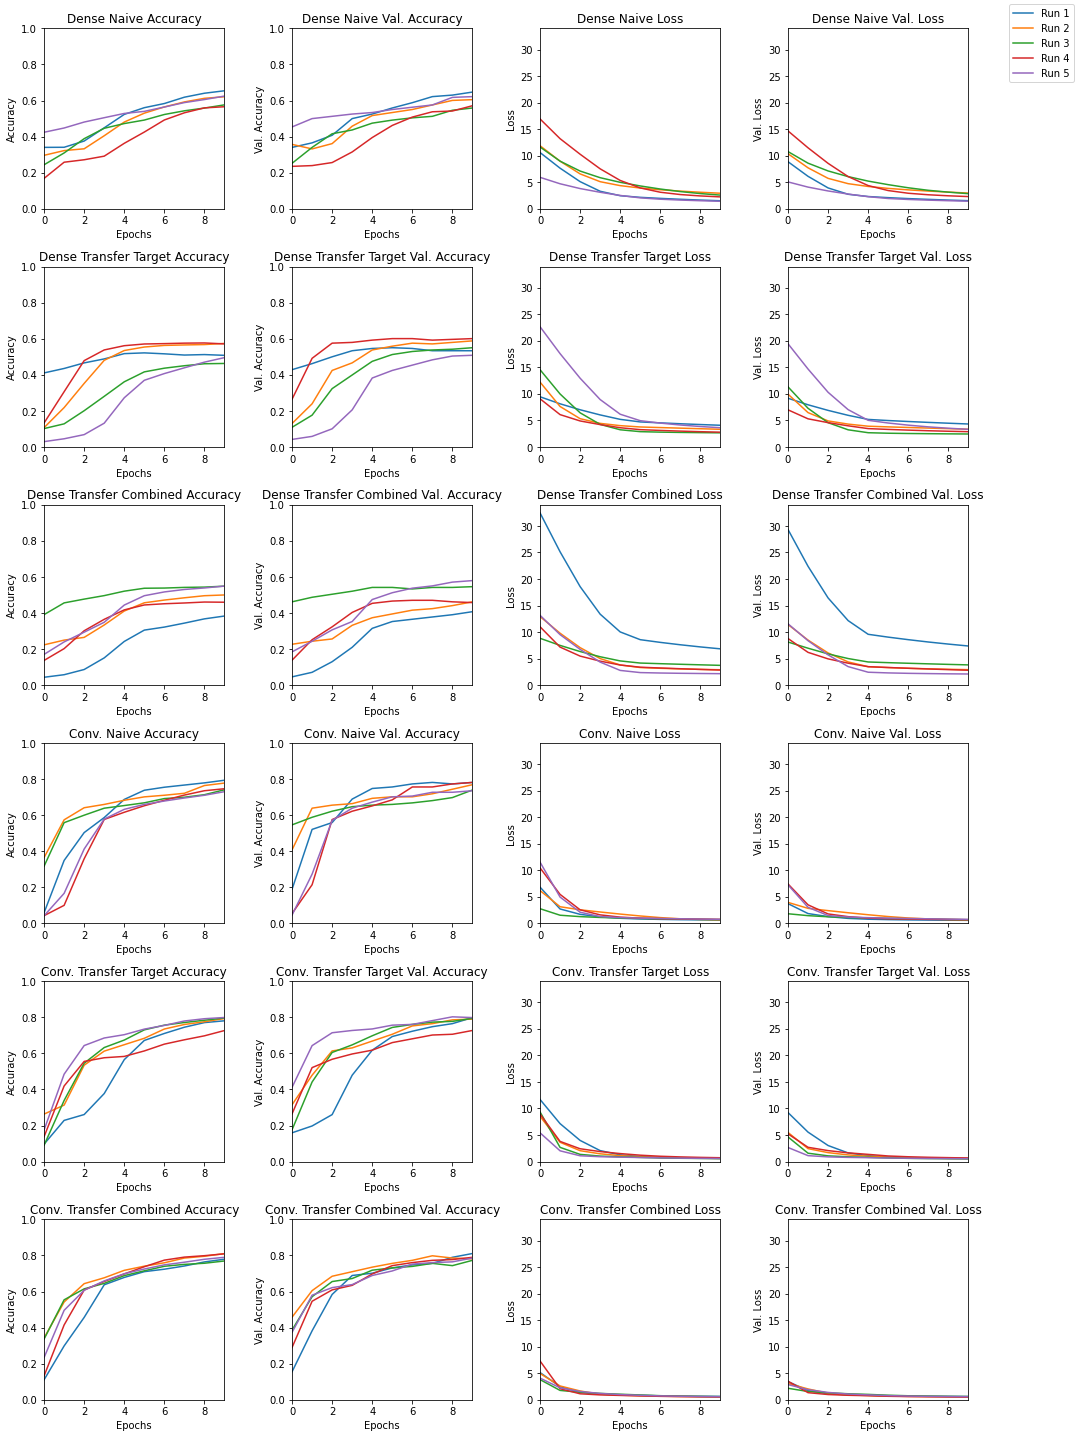

In [30]:
dual_handler = DualModelArchetypeHandler(exp_name, lables_to_values_map, save_dir=save_dir, 
                                         checkpoint_path=exp_checkpoint_path, checkpoint_file_name=cp_file
                                         )
dual_handler.run_experiment(input_shape_dense, input_shape_conv, 
                            dense_train_layers, conv_train_layers, 
                            data=data_new, n_labels=n_labels, learning_rate=learning_rate, drop=drop, 
                            epochs=epochs, n_runs=n_runs, 
                            verbose=False
                            )
tracker_global.update({exp_name: dual_handler.dual_tracker})
plot_histories(dual_handler, n_runs, epochs, save=True, save_dir=hist_plot_dir, save_name="%s_hist.png"%(exp_name))

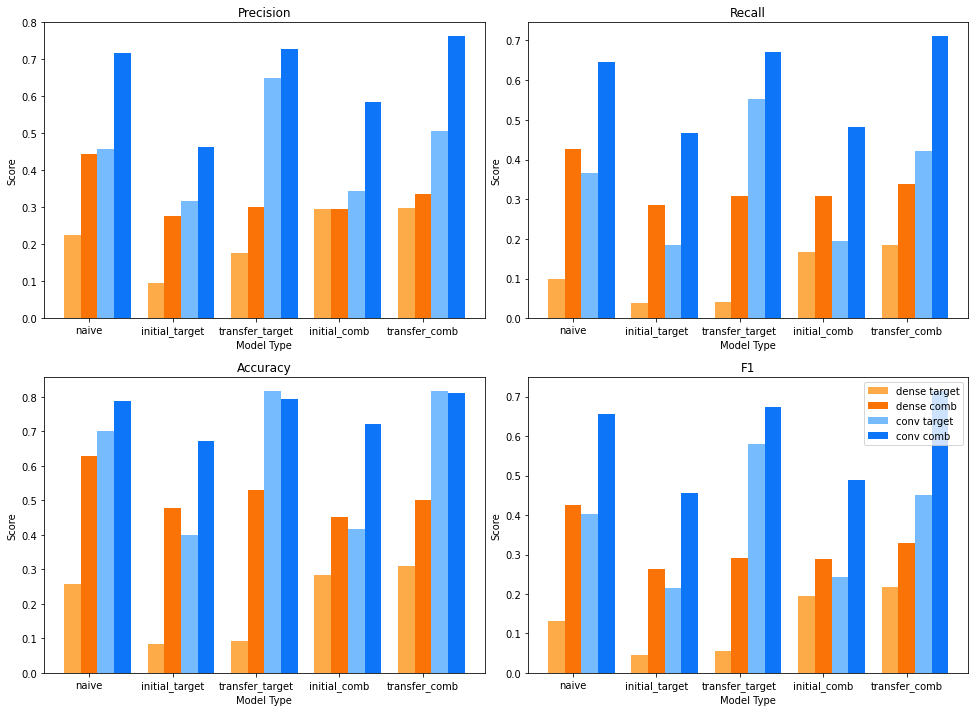

In [31]:
plot_scores(tracker_global[exp_name], save=True, save_dir=tracker_bar_dir, save_name="%s_bar.png"%(exp_name))